# Deep Solver for American Options

## 1.Market Model

Consider the price $S$ of our underlying follows the Black-Scholes dynamics
$$ \mathrm{d}S(t)=S(t)(r+\lambda) \mathrm{d}t + \sigma S(t) \mathrm{d}W(t), \quad t \in [0,T] $$
where $W$ is a one-dimensional Brownian Motion.

We assume that 

- $S(0)=1$,
- $r=0$ (Question: How does the optimal stopping problem proposed in the outline work for the pricing formula for American options when we need to discount, i. e. $r \neq 0$?),
- $\lambda = 0$ in order to directly work with the EMM,
- $\sigma = 1$ for convenience.

We hence have $S(t)=\exp(-\frac{1}{2}t+W(t)), \quad t \in [0,T]$. To simulate this process, we set up a function to compute the Euler-Maruyama discretization of a realization:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# set seed
torch.manual_seed(777)

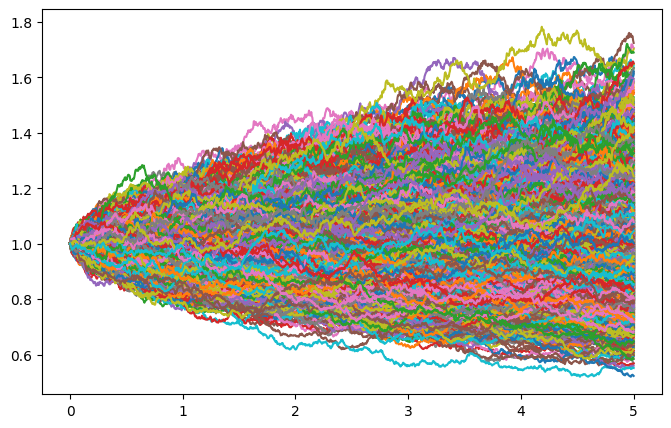

In [2]:
# Setting up Euler-Maruyama for this Example

def mu(s,mu=0):
    return(mu*s)

def sigma(s, sigma=1):
    return(sigma*s)

def euler_maruyama(mu,sigma,x_0,T,n,N):
    # x_0 = starting point of the process
    # T = time horizon
    # n = number of steps
    # N = number of simulations
    time_grid = np.linspace(0,T,n+1)
    x = np.random.normal(loc = 0, scale = T/n, size = (n,N))
    x = np.vstack([x_0*np.ones((1,N)),x])
    h = T/n
    for i in range(1,n+1): # Euler-Maruyama discretization
        x[i,] = x[i-1,] + mu(x[i-1,])*h+sigma(x[i-1,])*x[i,]
    return x

# generate a sample

x_0 = 1
T = 5
n = 1000
N = 10000

data = euler_maruyama(mu,sigma,x_0,T,n,N)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0,5,1001),data)
plt.show()

## 2. Price Process of the American Put

Let $g(x)=(K-x)_{+}$ be the payoff function of a vanilla American put option with strike price $K$. We want to compute the price of such an option, written on our underlying $S$, at time $t \in [0,T]$ and assuming the underlying is currently trading at $S(t)=x$. Since we are already working with an EMM and in a discounted market(see above), the risk neutral price (?) in this case is given by
$$
V(t,x)=\sup\limits_{\tau \in \Tau} \mathbb{E}[g(S^{t,x}(\tau))],
$$
where $\Tau$ is the set of all $[t,T]$-valued stopping times and $S^{t,x}$ is a process in the time interval $[t,T]$ that starts at $S^{t,x}(t)=x$ and follows the same dynamics as our initial process $S$.

$V$ can be characterized as the unique (viscosity?) solution of the PDE

$$\min \left(-V_t-\frac{1}{2}V_{xx},V-g \right) =0 \text{ on } [0,T)\times\mathbb{R} \quad \text{and} \quad V(T,\cdot)=g \text{ on } \mathbb{R}.$$

Furthermore, $V$ is the smallest function which dominates $g$ and satisfies

$$-V_t-\frac{1}{2}V_{xx} \geq 0 \text{ on } [0,T)\times \mathbb{R}.$$

## 3. Approximating $V$ with a Neural Network

### 3.1 Setting up the Neural Network

We want to approximate $V$ via neural networks $\{\hat{V}^\theta:\theta\in\Theta\}$. To already ensure that our approximating function dominates $g$, we use the modifications $V^\theta :=\max (\hat{V}^\theta,g)$.

To try this out, we choose $K=0.9$ and set up a corresponding neural network with following properties:

- 3 hidden layers à 10 hidden units
- sigmoid activation function for the 3 hidden layers

In [3]:
d = 1 # dimension of the spatial variable

K = 0.9 #strike price

# define payoff of an American put
def g(x):
    return torch.max(K-x, torch.tensor(0.0))[...,1].unsqueeze(-1)

# define neural network
class NeuralNet(nn.Module):
    def __init__(self, input=d+1, h1=10, h2=10, h3=10, output=1): # constructor method to initialize the parameters of the network, define the layers, etc. (see TUM LOOP)
        # Input = (x,t) -> hidden layer 1 (h1 hidden units) -> hidden layer 2 (h2 hidden units) -> hidden layer 3 (h3 hidden units) -> output U/V(x,t) 
        super(NeuralNet, self).__init__() # What is the purpose of this?
        self.fc1 = nn.Linear(input, h1) # linear combinations from input to hidden layer 1
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3,output)

    # define how an input moves forward through the net, esp. define the activation functions for the single layers (see Hastie et al.)
    def forward(self, x): # What does the "self" mean?
        
        g_values = g(x) 

        # Apply each layer
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = self.out(x)

        # Use torch.max on tensors directly, ensuring dimensions match
        return torch.max(x, g_values)


# Note: g and the NeuralNet are set up in such a way that one can insert a tensor of arbitrary shape as long as the last dimension equals d+1. Both will then be applied componentwise on the last dimension.

### 3.2 Setting up the Loss Function

- Now, we want to train this neural network with the simulated Euler-Maruyama data from above.

- Problem: Find an adequate loss function.

- First guess: $L(\theta) = \frac{1}{N} \sum\limits_{n=0}^N \mathbb{E}[V^\theta(t_n,\bar{X}_n)+\rho(-V_t(t_n,\bar{X}_n)-\frac{1}{2}V_{xx}(t_n,\bar{X}_n))]$, where $\bar{X}$ is an Euler-Maruyama discretization and $\rho >0$ a penalty parameter.

- In order to work with our `data` array of Euler-Maruyama trajectories, we will transform it into a `tensor` of shape (100,100,1001,2). We do this in such a way that we end up with 100 batches, each containing 100 Euler-Maruyama samples of shape (1001,2) (c.f. the construction of the `data` array with 10000 samples of Euler-Maruyama discretizations with 1001 time points each).

- The idea is the following: The loss function should take 1 batch as input to use the 100 sampled trajectories inherited in the single batch to compute 

In [4]:
# transforming the training data

training_sets = np.zeros((100,100,n+1,2))

training_sets[:,:,:,0] = np.linspace(0,T,n+1)

for i in range(100):
    for j in range(100):
        training_sets[i,j,:,1] = data[:,i*100+j]

training_sets = torch.tensor(training_sets, requires_grad=True) # requires_grad=true, so that the loss function can compute the gradients $V_t$ and $V_xx$.
training_sets = training_sets.float() # necessary at some step... (forgot to document where)

# penalty parameter
rho = 0.9

# define loss (important: use PyTorch operations)

# the input should have the shape (100,1001(=n+1),2(=t- and x-variable)), where 100 is the number of generated Euler-Maruyama trajectories we put into the loss function at once

def loss_fct(output, input):  
    grad_output = torch.ones_like(output)
    v_t = torch.autograd.grad(outputs=output, inputs=input,
                                              grad_outputs=grad_output,
                                              create_graph=True, retain_graph=True)[0][:, :, 0] # tensor with shape = (100,1001)
    
    v_x = torch.autograd.grad(outputs=output, inputs=input,
                                              grad_outputs=grad_output,
                                              create_graph=True, retain_graph=True)[0][:, :, 1]
    v_xx = torch.autograd.grad(outputs=v_x, inputs=input,
                                               grad_outputs=torch.ones_like(v_x),
                                               create_graph=True, retain_graph=True)[0][:, :, 1]
    v = output.squeeze(-1)
    loss = torch.sum(v + rho*(-v_t-0.5*v_xx))
    return(loss)

### 3.3 Training the Neural Network 

In [8]:
# instantiate the model
model = NeuralNet()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Training loop
for epoch in range(15):
    for i in range(25):
        sample = training_sets[i]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(sample)  # Add batch dimension

        # Compute the custom loss
        loss = loss_fct(output, sample)  # Add batch dimension

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

       # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")

Epoch: 0, Loss: 876.5917
Epoch: 10, Loss: 876.5917


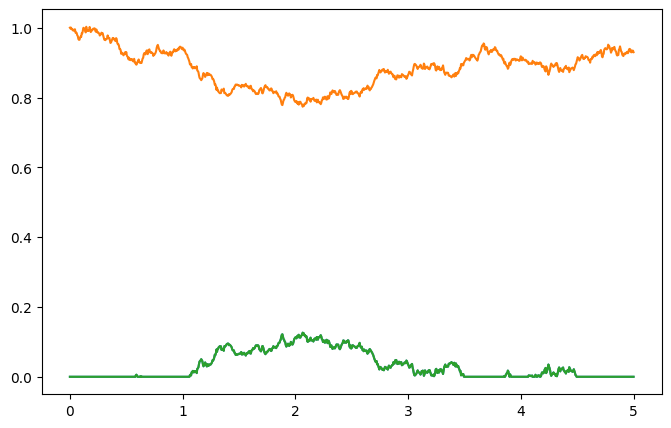

In [56]:
test=model(training_sets[6,7,...]).detach().cpu().numpy()
test2=training_sets[6,7,:,1].detach().cpu().numpy()
test = test.squeeze(-1).T
test2 = test2.T
test = np.vstack([test,test2,g(training_sets[6,7,:,:]).detach().cpu().numpy().T]).T

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0,5,1001),test)
plt.show()

Parameters = 0, V = g